# Classification of Experimental Data
I will use this notebook to load the experimental data and use my subimage classifier to predict if the device is in a single dot or a double dot region.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import glob
import scipy.interpolate

import matplotlib as mpl
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams.update({'font.size': 12})

import matplotlib.cm as cm
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['figure.dpi']= 100

## Loading of the experimental data

### May files
These are 9 useful files May1_i where i = 1...9. The centre gate voltage goes from $-0.6V$ to $-0.76V$ from i=1..9 files. 

(10000, 5)


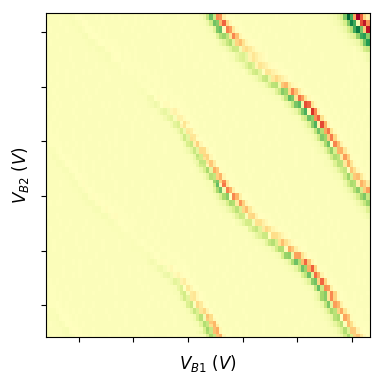

In [7]:
index = 2
filename = "/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/May1_" + str(index) + ".dat"
dat = np.loadtxt(filename)
print(dat.shape)

# values from the data
points = (dat[:,0],dat[:,2])
values = dat[:,3]

V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),100)
V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),100)
XX,YY = np.meshgrid(V_b1,V_b2)

z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest")
plt.pcolor(XX,YY,np.gradient(z)[1],cmap=cm.RdYlGn)
plt.xlabel(r"$V_{B1}\ (V)$")
plt.ylabel(r"$V_{B2}\ (V)$")
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.set_aspect('equal')
plt.tight_layout()

### April Files
These are large regions in the space of barrier gate voltages.

['/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_620.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_660.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_680.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_710.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_720.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_730.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_740.dat', '/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/Apr24_Vp_750.dat']
(14000, 5)


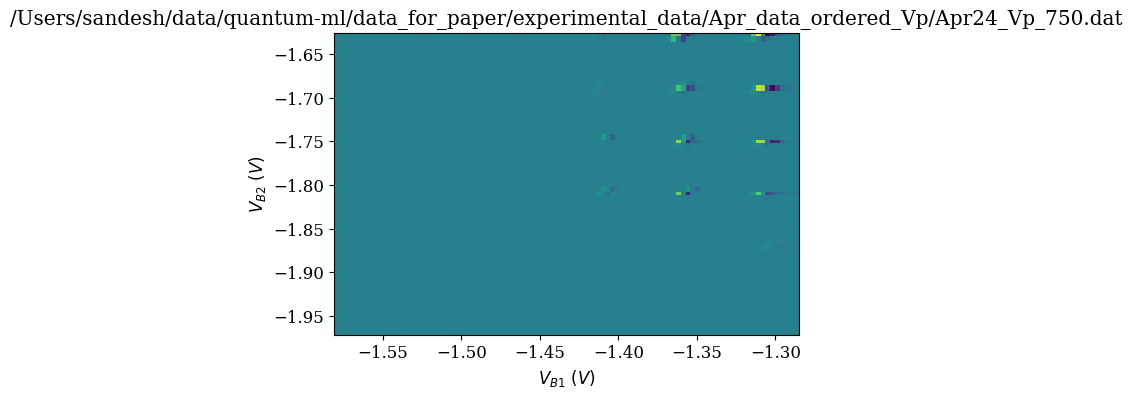

In [44]:
index = 7
files = sorted(glob.glob("/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/*.dat"))
print(files)
filename = files[index] 
dat = np.loadtxt(filename)
print(dat.shape)

# values from the data
points = (dat[:,0],dat[:,2])
values = dat[:,3]

V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),100)
V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),100)
XX,YY = np.meshgrid(V_b1,V_b2)

z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest")
plt.pcolor(XX,YY,np.gradient(z)[1])
plt.xlabel(r"$V_{B1}\ (V)$")
plt.ylabel(r"$V_{B2}\ (V)$")
#frame1 = plt.gca()
#frame1.axes.xaxis.set_ticklabels([])
#frame1.axes.yaxis.set_ticklabels([])
frame1.set_aspect('equal')
plt.title(filename)

### May files
The May files are like subimages. I will arrange them into a single array so that they can be tested on CNN.

In [ ]:
index = 2
filename = "/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/May1_" + str(index) + ".dat"
dat = np.loadtxt(filename)
print(dat.shape)

# values from the data
points = (dat[:,0],dat[:,2])
values = dat[:,3]

V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),100)
V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),100)
XX,YY = np.meshgrid(V_b1,V_b2)

z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest")
plt.pcolor(XX,YY,np.gradient(z)[1],cmap=cm.RdYlGn)
plt.xlabel(r"$V_{B1}\ (V)$")
plt.ylabel(r"$V_{B2}\ (V)$")
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.set_aspect('equal')
plt.tight_layout()

In [61]:
## organize the files into a single array to test on CNN
x_test_data = []
for index in range(1,10):
    filename = "/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/May1_" + str(index) + ".dat"
    dat = np.loadtxt(filename)

    # values from the data
    points = (dat[:,0],dat[:,2])
    values = dat[:,3]

    V_b1 = np.linspace(np.min(points[0]),np.max(points[0]),30)
    V_b2 = np.linspace(np.min(points[1]),np.max(points[1]),30)
    XX,YY = np.meshgrid(V_b1,V_b2)

    z = scipy.interpolate.griddata(points,values,(XX,YY),method="nearest") 
    x_test_data.append(z)
x_test_data = np.array(x_test_data)

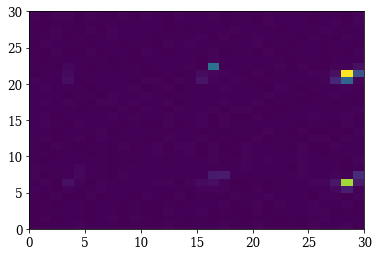

In [62]:
plt.pcolor(x_test_data[8])

## Testing of the CNN classifier 

In [101]:
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features["x"],[-1,30,30,1]),tf.float32)
    
    conv1 = tf.layers.conv2d(inputs=input_layer,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    
    conv2 = tf.layers.conv2d(inputs=pool1,
                            filters=16,
                            kernel_size=[5,5],
                            padding="same",
                            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    
    flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=flat,units=1024,activation=tf.nn.relu)  
    dropout1 = tf.layers.dropout(
      inputs=out1, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out2 = tf.layers.dense(inputs=dropout1,units=256,activation=tf.nn.relu)  
    dropout2 = tf.layers.dropout(
      inputs=out2, rate=0.5, training=mode == learn.ModeKeys.TRAIN)
    
    out = tf.layers.dense(inputs=dropout2, units=4)
    
    loss = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out)

    # Configure the training op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Generate predictions
    predictions= {
        "prob" : tf.nn.softmax(out),
        "states" : tf.argmax(out,axis=1)
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)


    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=tf.argmax(labels,axis=1), predictions=predictions["states"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [102]:
model_dir = "/Users/sandesh/trained_networks/substate_classifier_softmax/"
substate_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_save_checkpoints_steps': None, '_is_chief': True, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_id': 0, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x119fe9c50>, '_service': None, '_save_summary_steps': 100, '_task_type': 'worker', '_master': '', '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_model_dir': '/Users/sandesh/trained_networks/substate_classifier_softmax/'}


In [76]:
index = 1
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1e3*x_test_data[:]},
      y=None,
      num_epochs=1,
      shuffle=False)

predictions = list(substate_classifier.predict(input_fn=test_input_fn))
print("Dot state",[x['states']-1 for x in predictions])


INFO:tensorflow:Restoring parameters from /Users/sandesh/trained_networks/substate_classifier_softmax/model.ckpt-750
Dot state [1, 1, 1, 1, 1, 2, 2, 2, 2]


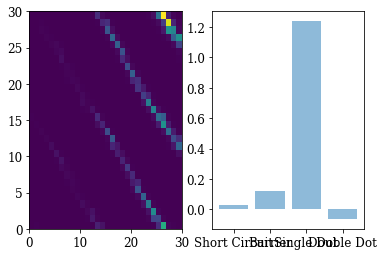

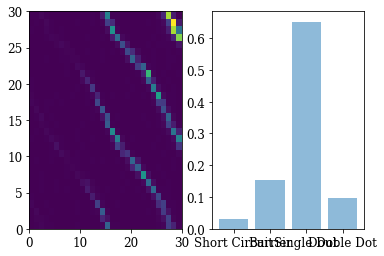

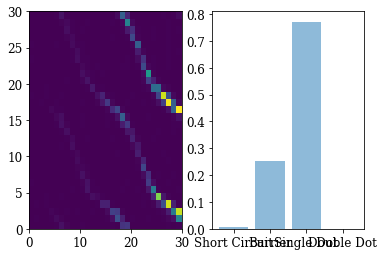

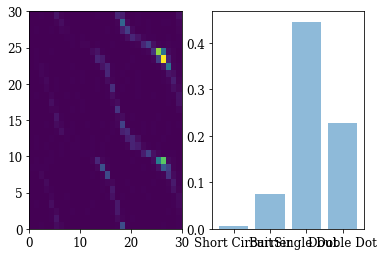

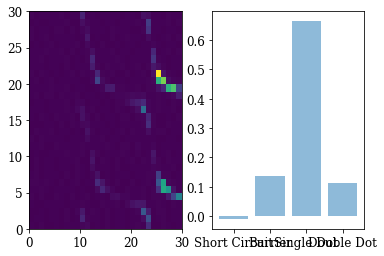

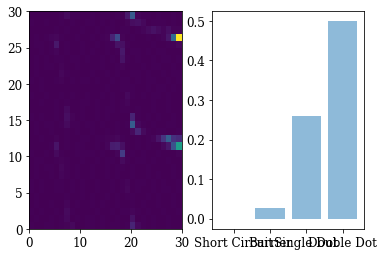

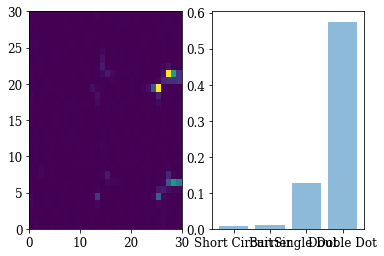

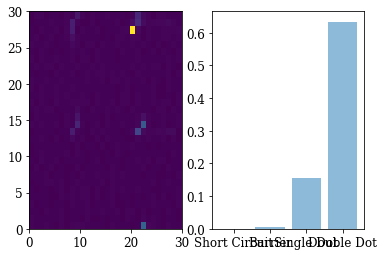

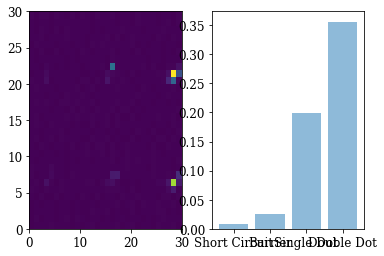

In [70]:
for i in range(len(predictions)):
    plt.figure(i)
    f,axarr = plt.subplots(1,2)
    axarr[0].pcolor(x_test_data[i])
    axarr[1].bar(np.arange(0,4),predictions[i]['prob'],alpha=0.5)
    axarr[1].set_xticks(np.arange(0,4))
    axarr[1].set_xticklabels(["Short Circuit","Barrier","Single Dot","Double Dot"])

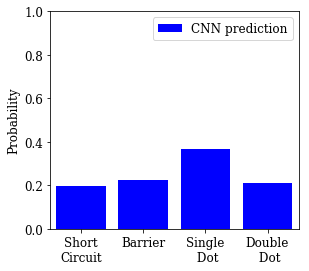

In [77]:
index = 0
fig,ax = plt.subplots()
prob = predictions[index]['prob']
plt.bar([0.5,1.5,2.5,3.5],prob,color='b',label="CNN prediction")
plt.ylim([0,1.0])
plt.ylabel("Probability")
plt.xlim([0,4.0])
ax.set_xticks([0.5,1.5,2.5,3.5])
ax.set_xticklabels(["Short\nCircuit", "Barrier", "Single\n Dot", "Double\n Dot"])
plt.legend()
ax.set_aspect(3.5)

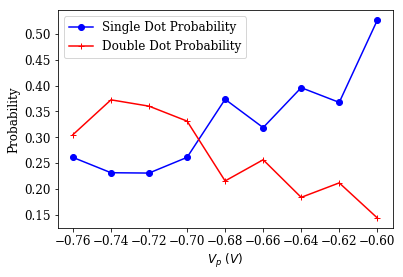

In [88]:
sd_prob = [x['prob'][2] for x in predictions]
dd_prob = [x['prob'][3] for x in predictions]
V_p_vec = np.linspace(-0.6,-0.76,len(predictions))
plt.plot(V_p_vec,sd_prob,'b-o',label="Single Dot Probability")
plt.plot(V_p_vec,dd_prob,'r-+',label="Double Dot Probability")
plt.ylabel("Probability")
plt.xlabel(r"$V_p\ (V)$")
plt.legend()
plt.savefig("/Users/sandesh/Desktop/exp_data_prob_trace.png",dpi=300)

## Testing of the Apr files
The Apr files are like full images. So I will take subimages of 100x100 full image.

### Organize the Apr files into a 3d array

In [178]:
files = sorted(glob.glob("/Users/sandesh/data/quantum-ml/data_for_paper/experimental_data/Apr_data_ordered_Vp/*.dat"))
Vp_array = np.array([-0.62,-0.66,-0.68,-0.71,-0.72,-0.73,-0.74,-0.75])
points = [[],[],[]]
values = []
for index in range(len(files)):
    filename = files[index] 
    dat = np.loadtxt(filename)

    # values from the data
    points[0] += list(dat[:,0])
    points[1] += list(dat[:,2])
    points[2] += [Vp_array[index]]*len(dat[:,0])
    values += list(dat[:,3])

tuple_points = (np.array(points[0]),np.array(points[1]),np.array(points[2]))
values = np.array(values)
V_b1 = np.linspace(np.min(tuple_points[0]),np.max(tuple_points[0]),100)
V_b2 = np.linspace(np.min(tuple_points[1]),np.max(tuple_points[1]),100)
V_p = np.linspace(Vp_array[0],Vp_array[-1],10)                            
                            
XX,YY,ZZ = np.meshgrid(V_b1,V_b2,V_p)

full_image = scipy.interpolate.griddata(tuple_points,values,(XX,YY,ZZ),method="nearest")

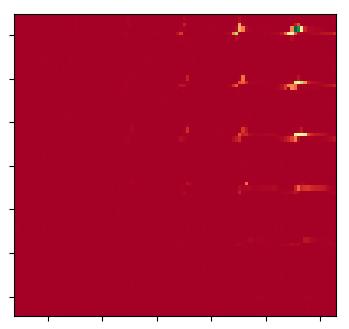

In [282]:
Vp_index = 90
plt.pcolormesh(XX[:,:,Vp_index],YY[:,:,Vp_index],full_image[:,:,Vp_index]/np.max(full_image[:,:,Vp_index]),cmap=cm.RdYlGn)
#plt.xlabel(r"$V_{b1}\ (V)$")
#plt.ylabel(r"$V_{b2}\ (V)$")
#cbar = plt.colorbar()
#cbar.set_label("Differential Conductance (arb. units)")
frame = plt.gca()
frame.set_aspect(0.8)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
#plt.title(r"$V_p = " + "{:.2f}".format(V_p[Vp_index]) + "$ V")
plt.savefig("/Users/sandesh/Desktop/full_exp_clean_4.png",dpi=300,pad_inches=0)


## Taking 2d subimages in 3d space

In [125]:
def create_subimage(pos,full_image,size):
    (x,y,z) = pos
    subimage = full_image[(x-size//2):(x + size//2),(y-size//2):(y+size//2),z]
    return subimage

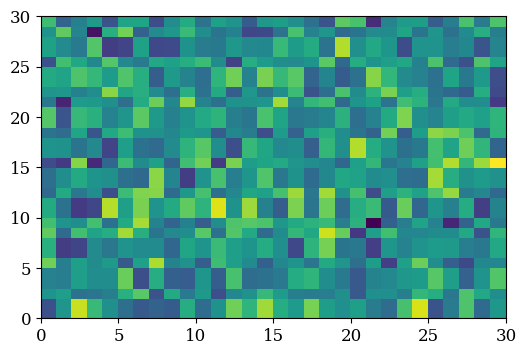

In [145]:
pos = (20,20,12)
subimage = create_subimage(pos,full_image,30) 
plt.pcolor(subimage)

In [151]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1e2*subimage},
      y=None,
      num_epochs=1,
      shuffle=False)

predictions = list(substate_classifier.predict(input_fn=test_input_fn))
print(predictions)

INFO:tensorflow:Restoring parameters from /Users/sandesh/trained_networks/substate_classifier_softmax/model.ckpt-750
[{'states': 1, 'prob': array([ 0.20015976,  0.32444885,  0.24520759,  0.23018384], dtype=float32)}]


## Plot of the fitness function

In [211]:
xrange = np.arange(15,84,1)
yrange = np.arange(15,84,1)
zrange = np.arange(0,100,1)
subimage_array = np.array([create_subimage((x,y,z),full_image,30) for x in xrange for y in yrange for z in zrange]) 

In [212]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : 1e2*subimage_array},
      y=None,
      shuffle=False)
predictions = list(substate_classifier.predict(input_fn=test_input_fn))
state_array = np.array([x['states'] for x in predictions]).reshape(len(xrange),len(yrange),len(zrange))

INFO:tensorflow:Restoring parameters from /Users/sandesh/trained_networks/substate_classifier_softmax/model.ckpt-750


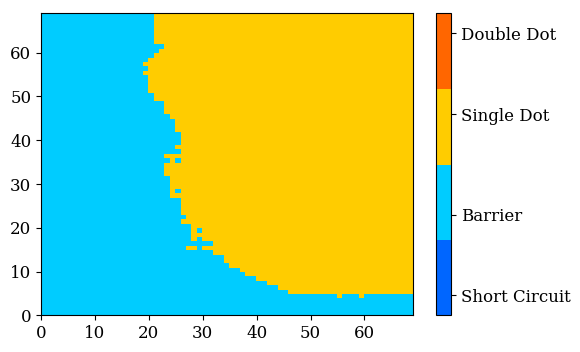

In [220]:
cmap = mpl.colors.ListedColormap([[0., .4, 1.], [0., .8, 1.],
                                  [1., .8, 0.], [1., .4, 0.]])
plt.figure(1)
plt.pcolor(state_array[:,:,14]-1,cmap=cmap,vmin=-1,vmax=2)
cbar = plt.colorbar()
cbar.set_ticks([-0.8,0,1,1.8])
cbar.set_ticklabels(["Short Circuit","Barrier","Single Dot", "Double Dot"])

In [227]:
prob_array = np.array([x['prob'] for x in predictions]).reshape(len(xrange),len(yrange),len(zrange),-1)
prob_0 = np.array([0,0,0,1])
def fitness(prob,prob_0):
    return np.linalg.norm(prob-prob_0)

fitness_array = np.array([fitness(x,prob_0) for x in prob_array.reshape(-1,4)]).reshape(len(xrange),len(yrange),len(zrange))


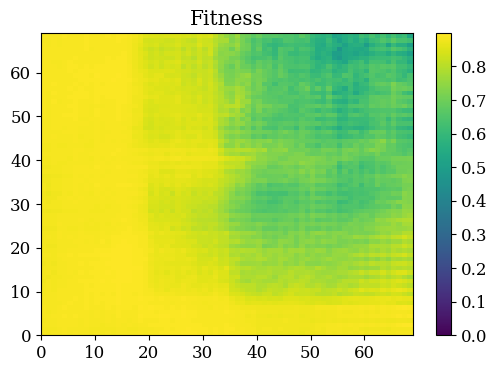

In [249]:
plt.pcolor(fitness_array[:,:,80],vmin=0)
plt.colorbar()
plt.title("Fitness")